In [1]:
import os
import pandas as pd
import numpy as np

path = '/Users/yuanzh/Google Drive/Files_PNC_Analysis'

# load subject info
filename = 'SubInfo_2018.txt'
sub = pd.read_csv(os.path.join(path, filename), header=0, delimiter='\t')
print("sub shape: " + str(sub.shape))
print("The first 3 columns are: " + str(sub.columns[0:3]))
sub.head(3)

num_sub = sub.shape[0]

sub shape: (759, 10)
The first 3 columns are: Index(['Subj', 'Age', 'Sex'], dtype='object')


In [2]:
# emotion condition (classes)
emotion = ['fear','anger','sad','happy'] # this is a list
#print(emotion)

# load connectivity into dictionary conn
path = '/Users/yuanzh/Google Drive/Files_PNC_Analysis'
path = path +'/BS_Conn_50ROIs_2018/Original Data'
#print(path)

df = {} # save connectivity under Fear, Anger, Sad, and Happy

for i in range(len(emotion)):
    filename = 'bs_conns_' + emotion[i] + '.txt'  
    #print(filename)
    conn = pd.read_csv(os.path.join(path, filename), header=0, delimiter='\t')
    # check the shape
    #print(conn.shape)
    # get name of the last unused column
    col = conn.columns[-1]
    #print("last column: " + str(col))
    # drop the last unused column
    conn = conn.drop(str(col),1)
    # check the shape
    #print(conn.shape)
    df[str(emotion[i])] = pd.concat([sub, conn], axis=1) #concat
    

In [3]:
# Data check
print(df.keys())
print(df[str(emotion[0])].shape)
df[str(emotion[0])].head(3)

dict_keys(['fear', 'anger', 'sad', 'happy'])
(759, 1236)


,Subj,Age,Sex,Race,GScore,GGroup,DScore,DGroup,Motion,Agebin,...,VLPFC.R_DLPFC.L,VLPFC.R_DLPFC.R,VLPFC.R_DLPFCm.L,VLPFC.R_DLPFCm.R,DLPFC.L_DLPFC.R,DLPFC.L_DLPFCm.L,DLPFC.L_DLPFCm.R,DLPFC.R_DLPFCm.L,DLPFC.R_DLPFCm.R,DLPFCm.L_DLPFCm.R
0,600009963128,9.666667,0,0,0,0,0,0,0.149664,Children,...,0.4722,0.9470,0.7317,1.2809,0.8010,0.0175,0.1136,0.2156,0.5137,1.2603
1,600018902293,15.583333,0,0,12,1,4,1,0.059930,Adolescents,...,0.3621,0.3730,0.5669,0.5315,1.1184,1.1773,1.0380,1.1589,0.6858,1.2571
2,600020364885,17.750000,1,0,2,1,0,0,0.056563,Adolescents,...,0.7979,0.4853,0.3248,0.6449,1.0761,0.0941,0.2069,-0.0811,0.1089,0.9859


In [4]:
# combine four emotion data
data = pd.concat([df["fear"],df["anger"],df["sad"],df["happy"]], axis=0)
print(data.shape)

(3036, 1236)


In [5]:
# replace missing values with column mean
def replace_nan(X):
    col_mean = np.nanmean(X, axis=0) # obtain column means
    ind = np.where(np.isnan(X)) # find the position of missing values
    X[ind] = np.take(col_mean, ind[1]) # replace nans with colmeans
    
    return X

In [13]:
# Prepare data for emotion classification

# Features
X = data.drop(columns = sub.columns) # drop subID, age, group etc.
#X.head(3)
X = X.drop(columns = X.columns[0]) # drop subID
#X.head(3)
X = X.values # convert pandas dataframe to numpy array
# print(X.shape)
#print(type(X))
X = replace_nan(X) # deal with missing values in numpy array
X = np.append(X, np.tile(sub['Age'],4).reshape(X.shape[0],1), axis=1) # include age as a predictor

# Labels
y = np.array([1,2,3,4]) 
y = np.repeat(y, num_sub)

# Groups
# Group info that will be used to do train-test split
# data belongs to the same subject should not be splited into different folds
G = np.array(range(num_sub)) +1
G = np.tile(G, 4).T
#print(G[0,759:789])
print('X shape: ' + str(X.shape) + '\ty shape: ' + str(y.shape) + '\tG shape: ' + str(G.shape))


X shape: (3036, 1226)	y shape: (3036,)	G shape: (3036,)


In [14]:
# import packages for svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GroupShuffleSplit

In [15]:
# train-test split for 10 fold cross validation; 
# samples that belong to the same subject will not be
# split into different folds
def get_cv(X, y, G):
    cv = GroupShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
    nfold = cv.get_n_splits()
    cv = cv.split(X, y, G)
    
    return cv, nfold

# train_inds, test_inds = next(cv) 

In [ ]:
"""
# Example of subsetting numpy array
a = np.arange(100).reshape(10,10)
#print(a)
n1, n2 = np.arange(5), np.arange(5)
#print(n1.shape)
b = a[n1[:,None],n2[None,:]]
b

n1 = np.concatenate((np.arange(100), np.arange(100)+759))
n1
"""

In [ ]:
"""
# Test using glmnet
import glmnet

model = glmnet.logistic.LogitNet(alpha=0.2)

inds = np.concatenate((np.arange(100), np.arange(100)+759, np.arange(100)+759*2, np.arange(100)+759*3))
m = model.fit(X[inds,:],y[inds])

m.predict(X[inds+100,:]) # this returns the predicted value at the best lambda
np.sum(m.predict == y[inds+100])
m.lambda_best_  # best lambda
m.lambda_best_inx_  # the position of the best lambda
"""

In [16]:
# organize data: which emotions are included, and which agebin are included
emotion_classes = 24 #['fear', 'anger']
age_range = 'FULL'
sub_info = sub['Age']
#print(sub_info)

# re-organize data for classification
def data_reorganize(emotion_classes, age_range, sub_info, X, y, G):
    nsub = len(sub_info)
    age = np.tile(sub_info, 4).T
    #print(age.shape)

    if emotion_classes == 1234:
        return X, y, G
    else:
        if emotion_classes == 12: # fear and anger
            inds = np.concatenate((np.arange(nsub), np.arange(nsub)+nsub))
        elif emotion_classes == 13: # fear and sad
            inds = np.concatenate((np.arange(nsub), np.arange(nsub)+nsub*2))
        elif emotion_classes == 14: # fear and happy
            inds = np.concatenate((np.arange(nsub), np.arange(nsub)+nsub*3))
        elif emotion_classes == 23: # anger and sad
            inds = np.concatenate((np.arange(nsub)+nsub, np.arange(nsub)+nsub*2))
        elif emotion_classes == 24: # anger and happy
            inds = np.concatenate((np.arange(nsub)+nsub, np.arange(nsub)+nsub*3))
        elif emotion_classes == 34: # sad and happy
            inds = np.concatenate((np.arange(nsub)+nsub*2, np.arange(nsub)+nsub*3))
       
        print(inds)

        X_input = X[inds,:]
        y_input = y[inds]
        G_input = G[inds]
        age_input = age[inds]

        if age_range == 'FULL':
            pass
        else:
            if age_range == 'CH':
                aind = np.where(age_input < 13)[0]
            elif age_range == 'ADO':
                aind = np.where(np.logical_and(age_input >= 13, age_input < 18))[0]
            elif age_range == 'ADU':
                aind = np.where(age_input >= 18)[0]

            X_input = X_input[aind,:]
            y_input = y_input[aind]
            G_input = G_input[aind]
    
        return X_input, y_input, G_input  
    

In [ ]:
# test 
emotion_classes = 12
age_range = 'FULL'
subj_age = sub['Age']
X_input, y_input, G_input = data_reorganize(emotion_classes, age_range, subj_age, X, y, G)

print(X_input.shape)
#print(y_input)
#print(G_input)

In [17]:
# four emotion, full age range
X_input, y_input, G_input = data_reorganize(1234, 'FULL', sub['Age'], X, y, G)
# fear vs. anger, full age range
#X_input, y_input, G_input = data_reorganize(12, 'ADU', sub['Age'], X, y, G)
# fear vs. sad, full age range
#X_input, y_input, G_input = data_reorganize(13, 'ADU', sub['Age'], X, y, G)
# fear vs. happy, full age range
#X_input, y_input, G_input = data_reorganize(14, 'FULL', sub['Age'], X, y, G)
# anger vs. sad, full age range
#X_input, y_input, G_input = data_reorganize(23, 'FULL', sub['Age'], X, y, G)
# anger vs. happy, full age range
#X_input, y_input, G_input = data_reorganize(24, 'FULL', sub['Age'], X, y, G)
# sad vs. happy, full age range
#X_input, y_input, G_input = data_reorganize(34, 'FULL', sub['Age'], X, y, G)

(1226,)


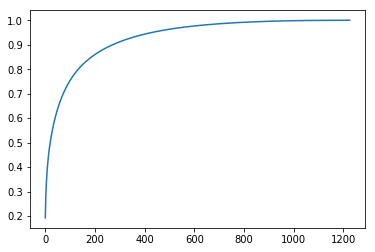

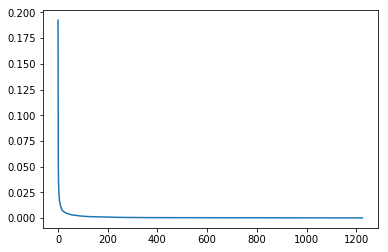

[0.19241707 0.05157997 0.03561344 0.02701444 0.02319971 0.01799252
 0.01602128 0.01531136 0.01512755 0.01216291 0.01176222 0.01078039
 0.01050216 0.0095748  0.00865947 0.00854976 0.00771877 0.00721064
 0.00712231 0.00697135 0.00671225 0.00632635 0.00626504 0.00604039
 0.00597962 0.00567294 0.00553335 0.00550169 0.00527487 0.00515848
 0.0049991  0.0049209  0.00481998 0.00460638 0.0045355  0.00450559
 0.00432698 0.00426459 0.00424459 0.00410244 0.00395944 0.00381839
 0.00378954 0.00374726 0.00368737 0.00366954 0.00363754 0.00355278
 0.00347909 0.00336936]


In [11]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(n_components=X_input.shape[1])
pca.fit(X_input)
print(pca.explained_variance_ratio_.shape)

plt.plot([i for i in range(X_input.shape[1])], 
         [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(X_input.shape[1])])
plt.show()

plt.plot([i for i in range(X_input.shape[1])], 
         [np.sum(pca.explained_variance_ratio_[i]) for i in range(X_input.shape[1])])
plt.show()

print(pca.explained_variance_ratio_[:50])

In [18]:
import glmnet

alpha_range = (np.arange(10)+1)*0.1
results = []

cv_splits, nfold = get_cv(X_input, y_input, G_input)
print("number of folds: " + str(nfold))
# get train and test indices for all folds
train_folds = []
test_folds = []

for train_inds, test_inds in cv_splits:
    train_folds.append(train_inds)
    test_folds.append(test_inds)


    
train_preds = []
test_preds = []

for alpha in alpha_range:
    print("alpha " + str(alpha))
    
    # nfold cross validation
    for fd in range(nfold):
    #for train_inds, test_inds in cv_splits:
        print("fold " + str(fd))
        X_train, y_train, X_test, y_test = X_input[train_folds[fd],:], y_input[train_folds[fd]], X_input[test_folds[fd],:], y_input[test_folds[fd]]
        
        # PCA 
        pca = PCA(n_components=100)
        pca.fit(X_train)
        X_train_reduction = pca.transform(X_train)
        X_test_reduction = pca.transform(X_test)
        
        model = glmnet.logistic.LogitNet(alpha=alpha)
        #m = model.fit(X_train,y_train)
        #train_preds = np.concatenate((train_preds, m.predict(X_train) == y_train))
        #test_preds = np.concatenate((test_preds, m.predict(X_test) == y_test))
        
        m = model.fit(X_train_reduction,y_train)
        train_preds = np.concatenate((train_preds, m.predict(X_train_reduction) == y_train))
        test_preds = np.concatenate((test_preds, m.predict(X_test_reduction) == y_test))
        
        results.append((alpha, m.lambda_best_, train_preds, test_preds, m)) 
        #print("training accuracy: " + str(np.mean(train_preds)) + " at alpha: " + str(alpha) + " and lambda: " + str(m.lambda_best_))
        #print("test accuracy " + str(np.mean(test_preds)) + " at alpha: " + str(alpha) + " and lambda: " + str(m.lambda_best_)) 
        fd += 1
    
    train_acc = np.mean(train_preds)
    test_acc = np.mean(test_preds)
    print("training accuracy (pca based): " + str(train_acc) + " at alpha: " + str(alpha))
    print("test accuracy (pca based)" + str(test_acc) + " at alpha: " + str(alpha))  
 

number of folds: 10
alpha 0.1
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
training accuracy (pca based): 0.37462932454695225 at alpha: 0.1
test accuracy (pca based)0.32088815789473685 at alpha: 0.1
alpha 0.2
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
training accuracy (pca based): 0.37489703459637563 at alpha: 0.2
test accuracy (pca based)0.31866776315789475 at alpha: 0.2
alpha 0.30000000000000004
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
training accuracy (pca based): 0.37690829214717186 at alpha: 0.30000000000000004
test accuracy (pca based)0.31798245614035087 at alpha: 0.30000000000000004
alpha 0.4
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
training accuracy (pca based): 0.3794686985172982 at alpha: 0.4
test accuracy (pca based)0.31842105263157894 at alpha: 0.4
alpha 0.5
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
training accuracy (pca based): 0.3786

In [ ]:
"""
import glmnet
# define my glmnet model (data normalization, glmnet)
def myGLMNet(alpha):
    pipe = Pipeline([
        ("std_scaler", StandardScaler()),
        ("glmnet", glmnet.logistic.LogitNet(alpha = alpha).fit())
    ])

# define evaluation
def evaluation(X, y, G, alpha):
    pipe = myGLMNet(alpha=alpha) 
    cv = get_cv(X, y, G)
        
    results = cross_validate(pipe, X, y, scoring=['accuracy'], cv=cv, verbose=1, return_train_score=True, n_jobs=-1)
    
    return results
    
alpha_range = [0.1,0.5] #np.logspace(-7, 1, 9)
models = []
for alpha in alpha_range:
        results = evaluation(X,y,G,alpha)
        models.append((alpha,results))
        print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),np.std(results['train_accuracy'])))
        print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),np.std(results['test_accuracy'])))
"""

In [ ]:
"""
# define my SVC model (data normalization, SVC)
def mySVC(gamma, C):
    return Pipeline([
        ("std_scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
"""

In [ ]:
# model = mySVC(gamma=1, C=0.1)
# model.fit(X_train,y_train)
# model.score(X_test, y_test)

In [ ]:
"""
def evaluation(X, y, G, gamma, C):
    pipe = mySVC(gamma=gamma, C=C) 
    cv = get_cv(X, y, G)
    #print("type(cv) = {}".format(type(cv)))
    
    results = cross_validate(pipe, X, y, scoring=['accuracy'], cv=cv, verbose=1, return_train_score=True, n_jobs=-1)
    
    return results
"""

In [ ]:
#results = evaluation(X,y,G,gamma=1,C=0.1)
#print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
#                                                         np.std(results['train_accuracy'])))
#print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
#                                                           np.std(results['test_accuracy'])))

In [ ]:
"""
C_range = np.exp2(np.array(range(-5,5))) #np.logspace(-3, 2, 6)
gamma_range = np.exp2(np.array(range(-10,1)))
models = []
for C in C_range:
    for gamma in gamma_range:
        results = evaluation(X,y,G,gamma,C)
        models.append((C,gamma,results))
        print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
        print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))
"""

In [ ]:
"""
# GridSearch
from sklearn.model_selection import GridSearchCV

# set the parameters
#tuned_parameters = [{'kernal': ['rbf'], 'gamma':[np.exp2(np.array(range(-2,2)))], 'C': [np.exp2(np.array(range(-2,2)))]}]

estimators = [("std_scaler", StandardScaler()), ("svc", SVC())]
tuned_parameters = [{'svc__gamma':[np.exp2(np.array(range(-2,2)))], 'svc__C': [np.exp2(np.array(range(-2,2)))]}]


pipe = Pipeline(estimators)
#cv = get_cv(X, y, G)
clf = GridSearchCV(pipe, param_grid = tuned_parameters, cv = 4, scoring='accuracy', n_jobs=-1)
clf.fit(X,y)

print('Best parameters set found: ')
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

"""